In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, TensorDataset

dtype = torch.FloatTensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 无优化的简单版本 Skip-Gram

# 文本预处理

In [3]:
# 文本预处理
sentences = ["jack like dog", "jack like cat", "jack like animal",
  "dog cat animal", "banana apple cat dog like", "dog fish milk like",
  "dog cat animal like", "jack like apple", "apple like", "jack like banana",
  "apple banana jack movie book music like", "cat dog hate", "cat dog like"]

word_sequence = " ".join(sentences).split() # ['jack', 'like', 'dog', 'jack', 'like', 'cat', 'animal',...]
vocab = list(set(word_sequence)) # build words vocabulary
word2idx = {w: i for i, w in enumerate(vocab)} # {'jack':0, 'like':1,...}

In [9]:
# Word2Vec Parameters
batch_size = 8
embedding_size = 2  # 2 dim vector represent one word
C = 2 # window size
voc_size = len(vocab)

In [10]:
# 准备数据
skip_grams = []
for idx in range(C, len(word_sequence) - C):
  center = word2idx[word_sequence[idx]] # center word
  context_idx = list(range(idx - C, idx)) + list(range(idx + 1, idx + C + 1)) # context word idx
  context = [word2idx[word_sequence[i]] for i in context_idx]
  for w in context:
    skip_grams.append([center, w])

# 2.
def make_data(skip_grams):
  input_data = []
  output_data = []
  for i in range(len(skip_grams)):
    input_data.append(np.eye(voc_size)[skip_grams[i][0]])
    output_data.append(skip_grams[i][1])
  return input_data, output_data

# 3.
input_data, output_data = make_data(skip_grams)
input_data, output_data = torch.Tensor(input_data), torch.LongTensor(output_data)
dataset = TensorDataset(input_data, output_data)
loader = DataLoader(dataset, batch_size, True)

In [19]:
# Model
class Word2Vec(nn.Module):
  def __init__(self):
    super(Word2Vec, self).__init__()

    # W and V is not Traspose relationship
    self.W = nn.Parameter(torch.randn(voc_size, embedding_size))
    self.V = nn.Parameter(torch.randn(embedding_size, voc_size))

  def forward(self, X):
    # X : [batch_size, voc_size] one-hot
    # torch.mm only for 2 dim matrix, but torch.matmul can use to any dim
    hidden_layer = torch.matmul(X, self.W) # hidden_layer : [batch_size, embedding_size]
    output_layer = torch.matmul(hidden_layer, self.V) # output_layer : [batch_size, voc_size]
    return output_layer

model = Word2Vec().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# Training
for epoch in range(2000):
  for i, (batch_x, batch_y) in enumerate(loader):
    batch_x = batch_x.to(device)
    batch_y = batch_y.to(device)
    pred = model(batch_x)
    loss = criterion(pred, batch_y)
    if (epoch + 1) % 1000 == 0:
      print(epoch + 1, i, loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

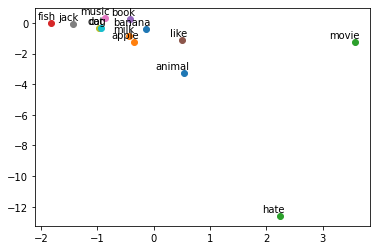

In [24]:
W, WT = model.parameters()
for i, label in enumerate(vocab):
  x,y = float(W[i][0]), float(W[i][1])
  plt.scatter(x, y)
  plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.show()

# Pytorch实现 使用负采样

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as tud

from collections import Counter
import numpy as np
import random

from sklearn.metrics.pairwise import cosine_similarity

random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

C = 3 # context window
K = 15 # number of negative samples
epochs = 2
MAX_VOCAB_SIZE = 10000
EMBEDDING_SIZE = 100
batch_size = 32
lr = 0.2

In [29]:
# read file
with open('./data/text8.train.txt') as f:
    text = f.read() # 得到文本内容

text = text.lower().split() #　分割成单词列表
vocab_dict = dict(Counter(text).most_common(MAX_VOCAB_SIZE - 1)) # 得到单词字典表，key是单词，value是次数
vocab_dict['<UNK>'] = len(text) - np.sum(list(vocab_dict.values())) # 把不常用的单词都编码为"<UNK>"， 此处市是 频次为1000的词
word2idx = {word:i for i, word in enumerate(vocab_dict.keys())}
idx2word = {i:word for i, word in enumerate(vocab_dict.keys())}
word_counts = np.array([count for count in vocab_dict.values()], dtype=np.float32)
word_freqs = word_counts / np.sum(word_counts)
word_freqs = word_freqs ** (3./4.)

In [39]:
# 构造数据集 len 为文本单词数量 get_item需要获取中心词 和 背景词 以及负采样词
class WordEmbeddingDataset(tud.Dataset):
    def __init__(self, text, word2idx, word_freqs):
        ''' text: a list of words, all text from the training dataset
            word2idx: the dictionary from word to index
            word_freqs: the frequency of each word
        '''
        super(WordEmbeddingDataset, self).__init__() # #通过父类初始化模型，然后重写两个方法
        self.text_encoded = [word2idx.get(word, word2idx['<UNK>']) for word in text] # 把单词数字化表示。如果不在词典中，也表示为unk
        self.text_encoded = torch.LongTensor(self.text_encoded) # nn.Embedding需要传入LongTensor类型
        self.word2idx = word2idx
        self.word_freqs = torch.Tensor(word_freqs)
        
        
    def __len__(self):
        return len(self.text_encoded) # 返回所有单词的总数，即item的总数
    
    def __getitem__(self, idx):
        ''' 这个function返回以下数据用于训练
            - 中心词
            - 这个单词附近的positive word
            - 随机采样的K个单词作为negative word
        '''
        center_words = self.text_encoded[idx] # 取得中心词
        pos_indices = list(range(idx - C, idx)) + list(range(idx + 1, idx + C + 1)) # 先取得中心左右各C个词的索引
        pos_indices = [i % len(self.text_encoded) for i in pos_indices] # 为了避免索引越界，所以进行取余处理
        pos_words = self.text_encoded[pos_indices] # tensor(list)
        
        neg_words = torch.multinomial(self.word_freqs, K * pos_words.shape[0], True)
        # torch.multinomial作用是对self.word_freqs做K * pos_words.shape[0]次取值，输出的是self.word_freqs对应的下标
        # 取样方式采用有放回的采样，并且self.word_freqs数值越大，取样概率越大
        # 每采样一个正确的单词(positive word)，就采样K个错误的单词(negative word)，pos_words.shape[0]是正确单词数量
        
        # while 循环是为了保证 neg_words中不能包含背景词
        while len(set(pos_indices) & set(neg_words.numpy().tolist())) > 0:
            neg_words = torch.multinomial(self.word_freqs, K * pos_words.shape[0], True)

        return center_words, pos_words, neg_words
dataset = WordEmbeddingDataset(text, word2idx, word_freqs)
dataloader = tud.DataLoader(dataset, batch_size, shuffle=True)

In [40]:
dataset.__getitem__(0)

(tensor(4813),
 tensor([  50, 9999,  393, 3139,   11,    5]),
 tensor([ 899,    6, 6510,   46,  224, 9998, 4840, 1604,  671, 3631, 9999,    6,
         3748, 4352,  264, 1127,  348, 8488,   38, 3089, 2315, 1026,   57, 2959,
          314, 5618, 2434,  120, 9999,   38,   37, 4345,  311, 1039, 7227, 3657,
           13, 3005, 9999,  191, 1944, 1705, 7465,  665, 2772, 4282,   63,  351,
         6303, 2229, 6091,   10, 7591, 3934, 4744, 1582, 7354, 3633, 1149,  511,
           14,  126, 4361, 7679, 8641,    5,  146,  222, 9846, 5108,    8,  413,
         1986, 5962, 1580, 9999, 2053,   14,   42,   91,  603,  154, 2729, 9117,
           52,  964, 9999,  286,   50,  888]))

In [46]:
# model
class EmbeddingModel(nn.Module):
    def __init__(self, vocab_size, embed_size):
        super(EmbeddingModel, self).__init__()
        
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        
        self.in_embed = nn.Embedding(self.vocab_size, self.embed_size) # 作为中心词的embedding
        self.out_embed = nn.Embedding(self.vocab_size, self.embed_size) # 作为背景词的embedding
        
    def forward(self, input_labels, pos_labels, neg_labels):
        ''' input_labels: center words, [batch_size]
            pos_labels: positive words, [batch_size, (window_size * 2)]
            neg_labels：negative words, [batch_size, (window_size * 2 * K)]
            
            return: loss, [batch_size]
        '''
        input_embedding = self.in_embed(input_labels) # [batch_size, embed_size]
        pos_embedding = self.out_embed(pos_labels)# [batch_size, (window * 2), embed_size]
        neg_embedding = self.out_embed(neg_labels) # [batch_size, (window * 2 * K), embed_size]
        
        input_embedding = input_embedding.unsqueeze(2) # [batch_size, embed_size, 1]
        
        pos_dot = torch.bmm(pos_embedding, input_embedding) # [batch_size, (window * 2), 1], 这一步要求和背景词接近
        pos_dot = pos_dot.squeeze(2) # [batch_size, (window * 2)]
        
        neg_dot = torch.bmm(neg_embedding, -input_embedding) # [batch_size, (window * 2 * K), 1]，这一步取负号要求和负采样词远离
        neg_dot = neg_dot.squeeze(2) # batch_size, (window * 2 * K)]
        
        log_pos = F.logsigmoid(pos_dot).sum(1) # .sum()结果只为一个数，.sum(1)结果是一维的张量
        log_neg = F.logsigmoid(neg_dot).sum(1)
        
        loss = log_pos + log_neg  # 理解成似然 = log(positive) + log(-negative)
        
        return -loss # 最小化
    
    def input_embedding(self):
        return self.in_embed.weight.detach().cpu().numpy()

model = EmbeddingModel(MAX_VOCAB_SIZE, EMBEDDING_SIZE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [43]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
for e in range(1):
    for i, (input_labels, pos_labels, neg_labels) in enumerate(dataloader):
        input_labels = input_labels.long().to(device)
        pos_labels = pos_labels.long().to(device)
        neg_labels = neg_labels.long().to(device)

        optimizer.zero_grad()
        loss = model(input_labels, pos_labels, neg_labels).mean()
        loss.backward() 

        optimizer.step()

        writer.add_scalar('Loss/train', loss.item(), i)
        # if i % 100 == 0:
        #     print('epoch', e, 'iteration', i, loss.item())

embedding_weights = model.input_embedding()
torch.save(model.state_dict(), "embedding-{}.pt".format(EMBEDDING_SIZE))

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:
# 寻找相似的单词
import scipy
def find_nearest(word):
    index = word2idx[word]
    embedding = embedding_weights[index]
    cos_dis = np.array([scipy.spatial.distance.cosine(e, embedding) for e in embedding_weights])
    return [idx2word[i] for i in cos_dis.argsort()[:10]]
for word in ["two", "america", "computer"]:
    print(word, find_nearest(word))
# 输出
# two ['two', 'zero', 'four', 'one', 'six', 'five', 'three', 'nine', 'eight', 'seven']
# america ['america', 'states', 'japan', 'china', 'usa', 'west', 'africa', 'italy', 'united', 'kingdom']
# computer ['computer', 'machine', 'earth', 'pc', 'game', 'writing', 'board', 'result', 'code', 'website']